# CNN for MNIST Image Classification

Data source: https://github.com/zalandoresearch/fashion-mnist

<ul>
    <li><a href="#data">Data</a></li>
    <li><a href="#model">Model</a></li>
    <li><a href="#training">Training</a></li>
    <li><a href="#results">Results</a></li>
</ul>

In [25]:
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
torch.manual_seed(0)

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

from PIL import Image

In [26]:
# Helper functions
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## <a name="data" id="data">Data</a>

- First, transform the dataset with `transforms.Compose()`. You can apply `Resize` and convert to `ToTensor`.
- Check data

In [27]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [28]:
train_dataset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

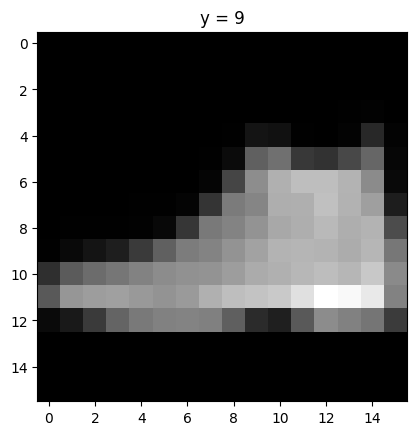

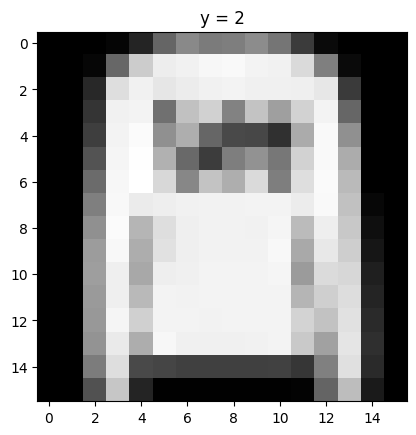

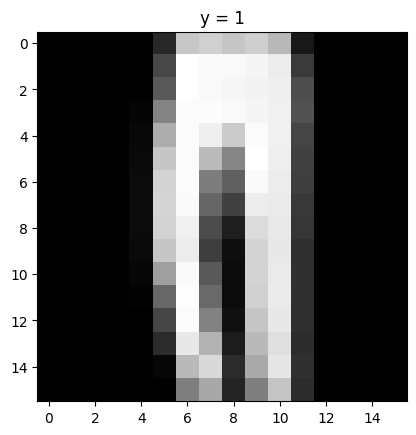

In [29]:
# Visualize data
for n, data_sample in enumerate(validation_dataset):

    show_data(data_sample)
    plt.show()
    if n==2:
        break 

## <a name="model" id="model">Model</a>

In [30]:
# Option A: regular CNN
class CNN(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [31]:
# Option B: CNN with Batch Normalization
class CNN_batch(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [32]:
# Data preparation
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100 )

In [33]:
model = CNN(out_1=16, out_2=32,number_of_classes=10)
#model =CNN_batch(out_1=16, out_2=32,number_of_classes=10)

In [34]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [35]:
print(model)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


## <a name="train" id="train">Train</a>

In [36]:
import time
start_time = time.time()

cost_list = []
accuracy_list = []

N_tests = len(validation_dataset)

n_epochs=5

for epoch in range(n_epochs):
    cost=0
    model.train()
    
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        
        loss.backward()
        optimizer.step()
        cost+=loss.item()
        
    #perform a prediction on the validation data
    correct = 0
    model.eval()
    # with torch.no_grad():
    for x_test, y_test in test_loader:
        z = model(x_test)
        _, y_hat = torch.max(z.data, 1)
        correct += (y_hat == y_test).sum().item()
    accuracy = correct / N_tests
    accuracy_list.append(accuracy)
    cost_list.append(cost)
    
print(f'Final accuracy: {accuracy:.4f}')
    

Final accuracy: 0.7994
Final accuracy: 0.8337
Final accuracy: 0.8501
Final accuracy: 0.8574
Final accuracy: 0.8645


## <a name="results" id="results">Results</a>

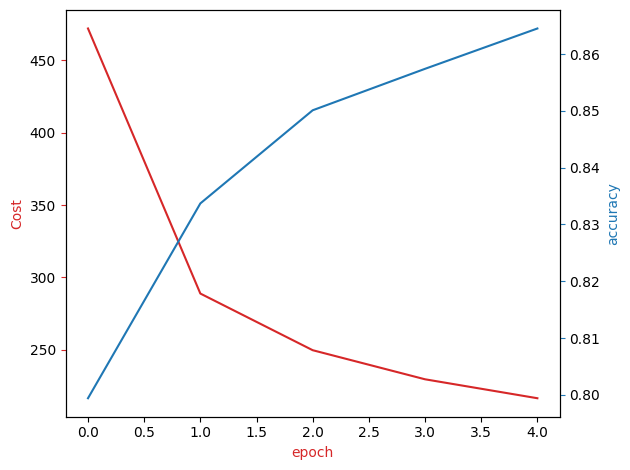

In [37]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()